In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment2/'
FOLDERNAME = 'cs231n/assignments/assignment2/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/MyDrive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/MyDrive/$FOLDERNAME

Mounted at /content/drive
/content/drive/MyDrive/cs231n/assignments/assignment2/cs231n/datasets
/content/drive/MyDrive/cs231n/assignments/assignment2


# Multi-Layer Fully Connected Network
In this exercise, you will implement a fully connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the network initialization, forward pass, and backward pass. Throughout this assignment, you will be implementing layers in `cs231n/layers.py`. You can re-use your implementations for `affine_forward`, `affine_backward`, `relu_forward`, `relu_backward`, and `softmax_loss` from Assignment 1. For right now, don't worry about implementing dropout or batch/layer normalization yet, as you will add those features later.


In [2]:
# Setup cell.
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

=========== You can safely ignore the message below if you are NOT working on ConvolutionalNetworks.ipynb ===========
	You will need to compile a Cython extension for a portion of this assignment.
	The instructions to do this will be given in a section of the notebook below.


In [3]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


## Initial Loss and Gradient Check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. This is a good way to see if the initial losses seem reasonable.

For gradient checking, you should expect to see errors around 1e-7 or less.

In [4]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print("Running check with reg = ", reg)
    model = FullyConnectedNet(
        [H1, H2],
        input_dim=D,
        num_classes=C,
        reg=reg,
        weight_scale=5e-2,
        dtype=np.float64
    )

    loss, grads = model.loss(X, y)
    print("Initial loss: ", loss)

    # Most of the errors should be on the order of e-7 or smaller.   
    # NOTE: It is fine however to see an error for W2 on the order of e-5
    # for the check when reg = 0.0
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print(f"{name} relative error: {rel_error(grad_num, grads[name])}")

Running check with reg =  0
Initial loss:  0.0
Running check with reg =  3.14
Initial loss:  0.0


As another sanity check, make sure your network can overfit on a small dataset of 50 images. First, we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 3.421561
(Epoch 0 / 20) train acc: 0.200000; val_acc: 0.118000
(Epoch 1 / 20) train acc: 0.360000; val_acc: 0.104000
(Epoch 2 / 20) train acc: 0.400000; val_acc: 0.132000
(Epoch 3 / 20) train acc: 0.720000; val_acc: 0.132000
(Epoch 4 / 20) train acc: 0.760000; val_acc: 0.130000
(Epoch 5 / 20) train acc: 0.920000; val_acc: 0.159000
(Iteration 11 / 40) loss: 0.759388
(Epoch 6 / 20) train acc: 0.900000; val_acc: 0.149000
(Epoch 7 / 20) train acc: 0.960000; val_acc: 0.145000
(Epoch 8 / 20) train acc: 0.960000; val_acc: 0.167000
(Epoch 9 / 20) train acc: 0.980000; val_acc: 0.164000
(Epoch 10 / 20) train acc: 0.960000; val_acc: 0.150000
(Iteration 21 / 40) loss: 0.328277
(Epoch 11 / 20) train acc: 0.960000; val_acc: 0.166000
(Epoch 12 / 20) train acc: 0.960000; val_acc: 0.168000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.167000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.156000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.165000
(Iteration 31 / 40) loss: 

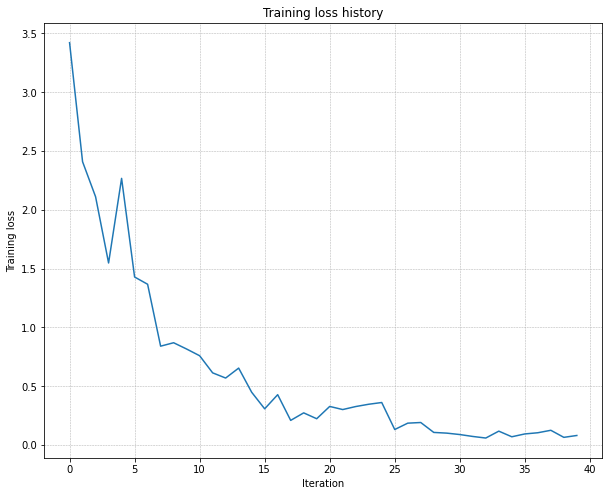

In [14]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  "X_train": data["X_train"][:num_train],
  "y_train": data["y_train"][:num_train],
  "X_val": data["X_val"],
  "y_val": data["y_val"],
}

weight_scale = 2e-2   # Experiment with this!
learning_rate = 3e-3  # Experiment with this!
model = FullyConnectedNet(
    [100, 100],
    weight_scale=weight_scale,
    dtype=np.float64
)
solver = Solver(
    model,
    small_data,
    print_every=10,
    num_epochs=20,
    batch_size=25,
    update_rule="sgd",
    optim_config={"learning_rate": learning_rate},
)
solver.train()

plt.plot(solver.loss_history)
plt.title("Training loss history")
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

Now, try to use a five-layer network with 100 units on each layer to overfit on 50 training examples. Again, you will have to adjust the learning rate and weight initialization scale, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 20.562261
(Epoch 0 / 20) train acc: 0.140000; val_acc: 0.106000
(Epoch 1 / 20) train acc: 0.280000; val_acc: 0.123000
(Epoch 2 / 20) train acc: 0.360000; val_acc: 0.140000
(Epoch 3 / 20) train acc: 0.680000; val_acc: 0.126000
(Epoch 4 / 20) train acc: 0.800000; val_acc: 0.133000
(Epoch 5 / 20) train acc: 0.880000; val_acc: 0.139000
(Iteration 11 / 40) loss: 0.845282
(Epoch 6 / 20) train acc: 0.940000; val_acc: 0.138000
(Epoch 7 / 20) train acc: 0.980000; val_acc: 0.130000
(Epoch 8 / 20) train acc: 1.000000; val_acc: 0.123000
(Epoch 9 / 20) train acc: 1.000000; val_acc: 0.131000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.129000
(Iteration 21 / 40) loss: 0.018648
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.130000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.127000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.130000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.128000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.133000
(Iteration 31 / 40) loss:

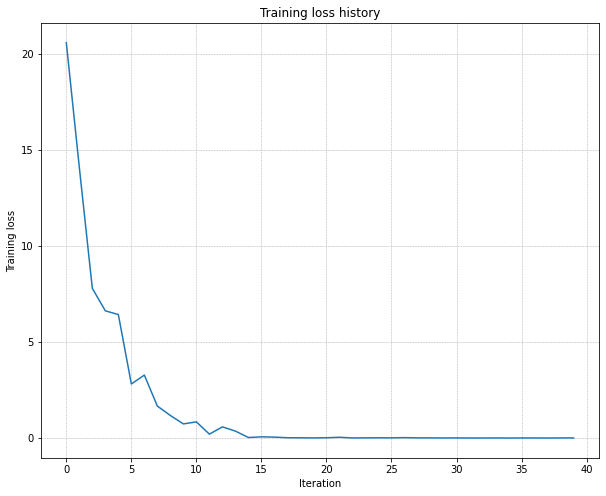

In [24]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 2e-3  # Experiment with this!
weight_scale = 7e-2   # Experiment with this!
model = FullyConnectedNet(
    [100, 100, 100, 100],
    weight_scale=weight_scale,
    dtype=np.float64
)
solver = Solver(
    model,
    small_data,
    print_every=10,
    num_epochs=20,
    batch_size=25,
    update_rule='sgd',
    optim_config={'learning_rate': learning_rate},
)
solver.train()

plt.plot(solver.loss_history)
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

## Inline Question 1: 
Did you notice anything about the comparative difficulty of training the three-layer network vs. training the five-layer network? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?

## Answer:
[FILL THIS IN]


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

## SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum Update section at http://cs231n.github.io/neural-networks-3/#sgd for more information.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than e-8.

In [26]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {"learning_rate": 1e-3, "velocity": v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print("next_w error: ", rel_error(next_w, expected_next_w))
print("velocity error: ", rel_error(expected_velocity, config["velocity"]))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

Running with  sgd
(Iteration 1 / 200) loss: 3.277135
(Epoch 0 / 5) train acc: 0.086000; val_acc: 0.103000
(Iteration 11 / 200) loss: 2.217707
(Iteration 21 / 200) loss: 2.252073
(Iteration 31 / 200) loss: 2.216924
(Epoch 1 / 5) train acc: 0.252000; val_acc: 0.202000
(Iteration 41 / 200) loss: 2.069981
(Iteration 51 / 200) loss: 2.075539
(Iteration 61 / 200) loss: 2.127678
(Iteration 71 / 200) loss: 1.855705
(Epoch 2 / 5) train acc: 0.286000; val_acc: 0.257000
(Iteration 81 / 200) loss: 2.000744
(Iteration 91 / 200) loss: 2.084133
(Iteration 101 / 200) loss: 1.910885
(Iteration 111 / 200) loss: 2.078857
(Epoch 3 / 5) train acc: 0.322000; val_acc: 0.257000
(Iteration 121 / 200) loss: 1.957243
(Iteration 131 / 200) loss: 1.937320
(Iteration 141 / 200) loss: 1.864715
(Iteration 151 / 200) loss: 1.847569
(Epoch 4 / 5) train acc: 0.365000; val_acc: 0.298000
(Iteration 161 / 200) loss: 1.801255
(Iteration 171 / 200) loss: 1.801075
(Iteration 181 / 200) loss: 1.890331
(Iteration 191 / 200) los

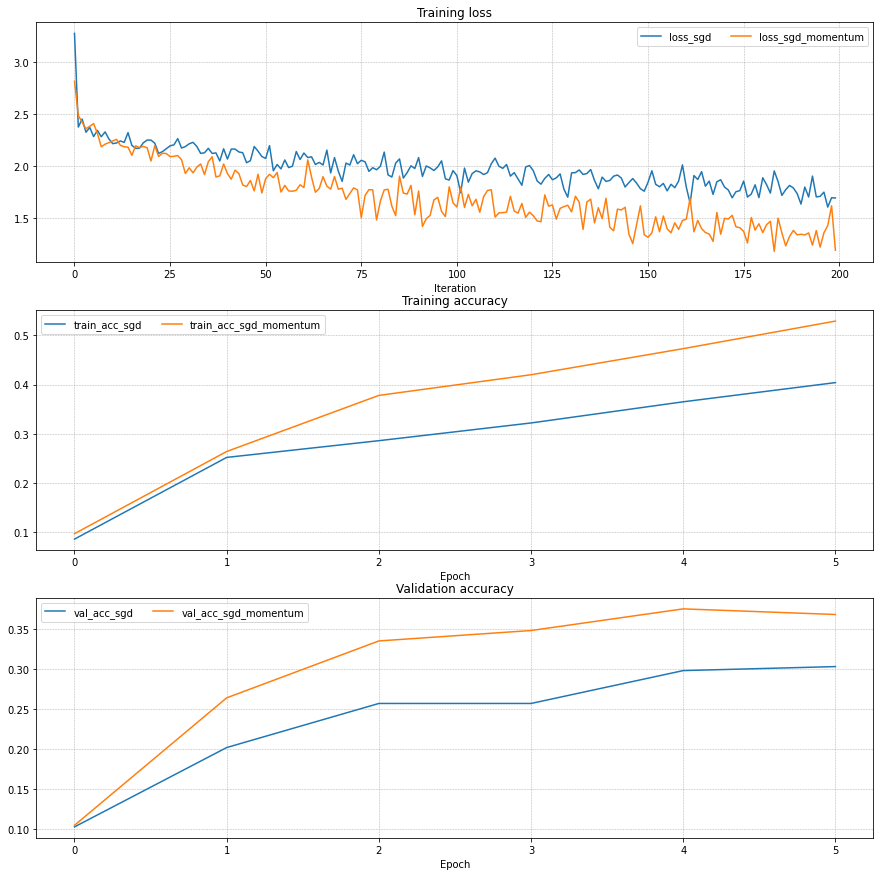

In [27]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )

    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': 5e-3},
        verbose=True,
    )
    solvers[update_rule] = solver
    solver.train()

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"loss_{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"train_acc_{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"val_acc_{update_rule}")
    
for ax in axes:
    ax.legend(loc="best", ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

## RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

**NOTE:** Please implement the _complete_ Adam update rule (with the bias correction mechanism), not the first simplified version mentioned in the course notes. 

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [30]:
# Test RMSProp implementation
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [31]:
# Test Adam implementation
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

Running with  adam
(Iteration 1 / 200) loss: 2.422155
(Epoch 0 / 5) train acc: 0.151000; val_acc: 0.138000
(Iteration 11 / 200) loss: 1.998983
(Iteration 21 / 200) loss: 2.029339
(Iteration 31 / 200) loss: 1.859179
(Epoch 1 / 5) train acc: 0.366000; val_acc: 0.333000
(Iteration 41 / 200) loss: 1.819262
(Iteration 51 / 200) loss: 1.813245
(Iteration 61 / 200) loss: 1.564529
(Iteration 71 / 200) loss: 1.689319
(Epoch 2 / 5) train acc: 0.408000; val_acc: 0.357000
(Iteration 81 / 200) loss: 1.618923
(Iteration 91 / 200) loss: 1.571641
(Iteration 101 / 200) loss: 1.562570
(Iteration 111 / 200) loss: 1.530574
(Epoch 3 / 5) train acc: 0.454000; val_acc: 0.361000
(Iteration 121 / 200) loss: 1.506899
(Iteration 131 / 200) loss: 1.419822
(Iteration 141 / 200) loss: 1.483076
(Iteration 151 / 200) loss: 1.417491
(Epoch 4 / 5) train acc: 0.512000; val_acc: 0.389000
(Iteration 161 / 200) loss: 1.496942
(Iteration 171 / 200) loss: 1.578813
(Iteration 181 / 200) loss: 1.386011
(Iteration 191 / 200) lo

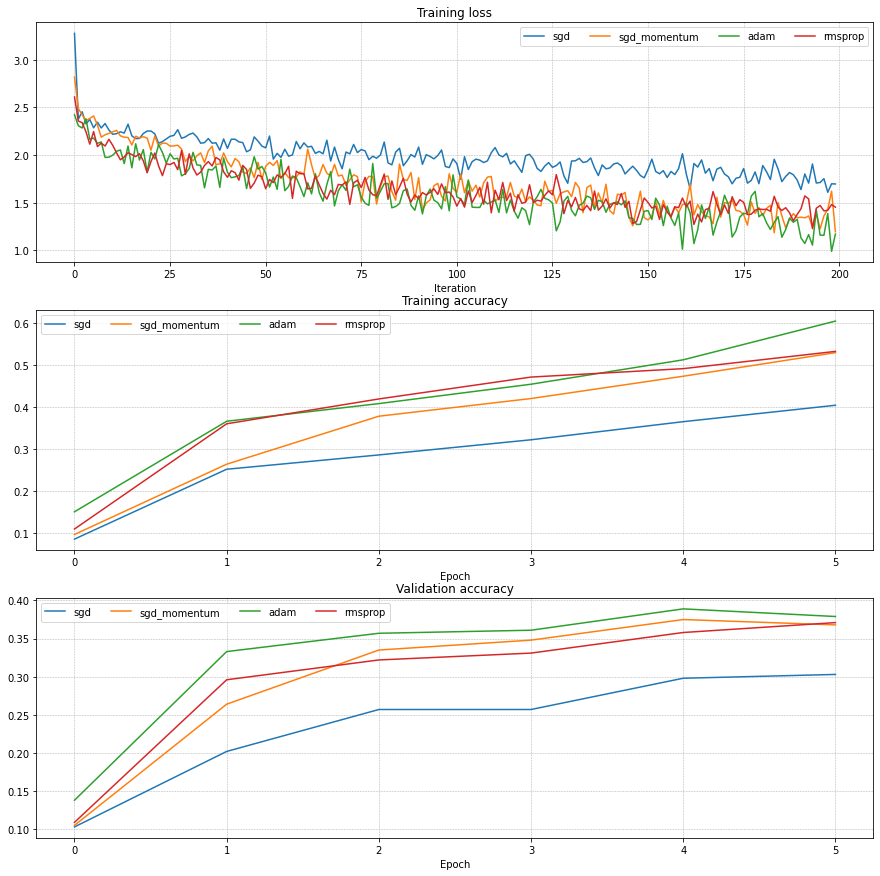

In [32]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )
    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': learning_rates[update_rule]},
        verbose=True
    )
    solvers[update_rule] = solver
    solver.train()
    print()
    
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"{update_rule}")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

## Inline Question 2:

AdaGrad, like Adam, is a per-parameter optimization method that uses the following update rule:

```
cache += dw**2
w += - learning_rate * dw / (np.sqrt(cache) + eps)
```

John notices that when he was training a network with AdaGrad that the updates became very small, and that his network was learning slowly. Using your knowledge of the AdaGrad update rule, why do you think the updates would become very small? Would Adam have the same issue?


## Answer: 
[FILL THIS IN]


# Train a Good Model!
Train the best fully connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully connected network.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional networks rather than fully connected networks.

**Note:** You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [55]:
best_model = None

################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

def generate_random_hyperparams(lr, reg, hidden_size, epoch_values):
  lr = 10 ** np.random.uniform(lr[0], lr[1])
  reg = 10 ** np.random.uniform(reg[0], reg[1])
  hidden_size = np.random.randint(hidden_size[0], hidden_size[1])
  epochs = epoch_values[np.random.randint(0, len(epoch_values))]

  return lr, reg, hidden_size, epochs

grid_search = [generate_random_hyperparams((-2, -4), (-7, -3), (50, 200), (10, 20)) for count in range(10)]

best_val = -1
results = {}

for config_num, config in enumerate(grid_search):
    print("Hyperparam config #{} of #{} -> ".format(config_num + 1, len(grid_search)), end = '')

    lr, reg, hidden_size, epochs = config
    print("lr: {:.2e}, reg: {:.2e}, hidden_size: {:.2e}, epochs: {:.2e}".format(lr, reg, hidden_size, epochs))

    model = TwoLayerNet(hidden_size = hidden_size, reg = reg)
    current_solver = Solver(model, data, update_rule = 'sgd', optim_config = {'learning_rate': lr},
                            lr_decay = 0.95, num_epochs = epochs, batch_size = 100, 
                            print_every = 100, verbose = False)
    
    current_solver.train()
    
    if current_solver.best_val_acc > best_val: 
        best_val = current_solver.best_val_acc
        best_model = model

    print('Validation accuracy: %.4f' % (current_solver.best_val_acc,))
    print()
    
print('Best validation accuracy achieved: %.4f' % best_val)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

Hyperparam config #1 of #10 -> lr: 9.78e-03, reg: 1.04e-05, hidden_size: 1.06e+02, epochs: 1.00e+01


/content/drive/MyDrive/cs231n/assignments/assignment2/cs231n/layers.py:151: RuntimeWarning: overflow encountered in subtract
  shifted_logits = x - np.max(x, axis = 1, keepdims = True)
/content/drive/MyDrive/cs231n/assignments/assignment2/cs231n/layers.py:151: RuntimeWarning: invalid value encountered in subtract
  shifted_logits = x - np.max(x, axis = 1, keepdims = True)


Validation accuracy: 0.1620

Hyperparam config #2 of #10 -> lr: 4.94e-04, reg: 1.20e-05, hidden_size: 1.44e+02, epochs: 1.00e+01
Validation accuracy: 0.5290

Hyperparam config #3 of #10 -> lr: 1.29e-03, reg: 8.76e-06, hidden_size: 1.42e+02, epochs: 2.00e+01
Validation accuracy: 0.5340

Hyperparam config #4 of #10 -> lr: 4.40e-03, reg: 2.67e-06, hidden_size: 1.48e+02, epochs: 2.00e+01


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Validation accuracy: 0.1480

Hyperparam config #5 of #10 -> lr: 4.84e-03, reg: 1.10e-04, hidden_size: 7.60e+01, epochs: 1.00e+01
Validation accuracy: 0.1440

Hyperparam config #6 of #10 -> lr: 2.60e-04, reg: 6.28e-04, hidden_size: 1.26e+02, epochs: 1.00e+01
Validation accuracy: 0.4990

Hyperparam config #7 of #10 -> lr: 3.09e-04, reg: 3.72e-06, hidden_size: 1.99e+02, epochs: 2.00e+01
Validation accuracy: 0.5470

Hyperparam config #8 of #10 -> lr: 3.81e-04, reg: 3.03e-05, hidden_size: 1.61e+02, epochs: 2.00e+01
Validation accuracy: 0.5520

Hyperparam config #9 of #10 -> lr: 1.13e-04, reg: 3.41e-05, hidden_size: 1.72e+02, epochs: 1.00e+01
Validation accuracy: 0.4720

Hyperparam config #10 of #10 -> lr: 6.28e-04, reg: 1.40e-04, hidden_size: 9.10e+01, epochs: 2.00e+01
Validation accuracy: 0.5330

Best validation accuracy achieved: 0.5520


In [54]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

from cs231n.layers import *
from cs231n.layer_utils import *

class TwoLayerNet(object):
  """
  A two-layer fully-connected neural network. The net has an input dimension of
  N, a hidden layer dimension of H, and performs classification over C classes.
  We train the network with a softmax loss function and L2 regularization on the
  weight matrices. The network uses a ReLU nonlinearity after the first fully
  connected layer.
  In other words, the network has the following architecture:
  input - fully connected layer - ReLU - fully connected layer - softmax
  The outputs of the second fully-connected layer are the scores for each class.
  """

  def __init__(self,  hidden_size=100, reg=0.0, input_size=32*32*3, output_size=10, std=1e-4):
    """
    Initialize the model. Weights are initialized to small random values and
    biases are initialized to zero. Weights and biases are stored in the
    variable self.params, which is a dictionary with the following keys:
    W1: First layer weights; has shape (D, H)
    b1: First layer biases; has shape (H,)
    W2: Second layer weights; has shape (H, C)
    b2: Second layer biases; has shape (C,)
    Inputs:
    - input_size: The dimension D of the input data.
    - hidden_size: The number of neurons H in the hidden layer.
    - output_size: The number of classes C.
    """
    self.params = {}
    self.params['W1'] = std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size) 
    self.params['W2'] = std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

  def loss(self, X, y=None, reg=0.0):
    """
    Compute the loss and gradients for a two layer fully connected neural
    network.
    Inputs:
    - X: Input data of shape (N, D). Each X[i] is a training sample.
    - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
      an integer in the range 0 <= y[i] < C. This parameter is optional; if it
      is not passed then we only return scores, and if it is passed then we
      instead return the loss and gradients.
    - reg: Regularization strength.
    Returns:
    If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
    the score for class c on input X[i].
    If y is not None, instead return a tuple of:
    - loss: Loss (data loss and regularization loss) for this batch of training
      samples.
    - grads: Dictionary mapping parameter names to gradients of those parameters
      with respect to the loss function; has the same keys as self.params.
    """
    # Unpack variables from the params dictionary
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']

    # Compute the forward pass
    scores = None
    #############################################################################
    # TODO: Perform the forward pass, computing the class scores for the input. #
    # Store the result in the scores variable, which should be an array of      #
    # shape (N, C).                                                             #
    #############################################################################
    
    A1, cache1 = affine_relu_forward(X, W1, b1)
    scores, cache2 = affine_forward(A1, W2, b2)
    
    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################
    
    # If the targets are not given then jump out, we're done
    if y is None:
      return scores

    # Compute the loss
    loss = 0.0
    #############################################################################
    # TODO: Finish the forward pass, and compute the loss. This should include  #
    # both the data loss and L2 regularization for W1 and W2. Store the result  #
    # in the variable loss, which should be a scalar. Use the Softmax           #
    # classifier loss. So that your results match ours, multiply the            #
    # regularization loss by 0.5                                                #
    #############################################################################
    
    loss, dscores = softmax_loss(scores, y)

    loss += 0.5 * reg * (np.sum(W1 * W1) + np.sum(W2 * W2))

    dA1, dW2, db2 = affine_backward(dscores, cache2)
    dX, dW1, db1 = affine_relu_backward(dA1, cache1)
    
    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################

    # Backward pass: compute gradients
    grads = {}
    #############################################################################
    # TODO: Compute the backward pass, computing the derivatives of the weights #
    # and biases. Store the results in the grads dictionary. For example,       #
    # grads['W1'] should store the gradient on W1, and be a matrix of same size #
    #############################################################################
    
    grads['W2'] = dW2 + reg * W2
    grads['b2'] = db2
    grads['W1'] = dW1 + reg * W1
    grads['b1'] = db1
    
    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################

    return loss, grads

  def train(self, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this neural network using stochastic gradient descent.
    Inputs:
    - X: A numpy array of shape (N, D) giving training data.
    - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
      X[i] has label c, where 0 <= c < C.
    - X_val: A numpy array of shape (N_val, D) giving validation data.
    - y_val: A numpy array of shape (N_val,) giving validation labels.
    - learning_rate: Scalar giving learning rate for optimization.
    - learning_rate_decay: Scalar giving factor used to decay the learning rate
      after each epoch.
    - reg: Scalar giving regularization strength.
    - num_iters: Number of steps to take when optimizing.
    - batch_size: Number of training examples to use per step.
    - verbose: boolean; if true print progress during optimization.
    """
    num_train = X.shape[0]
    iterations_per_epoch = max(num_train / batch_size, 1)

    # Use SGD to optimize the parameters in self.model
    loss_history = []
    train_acc_history = []
    val_acc_history = []

    for it in range(num_iters):
      X_batch = None
      y_batch = None

      #########################################################################
      # TODO: Create a random minibatch of training data and labels, storing  #
      # them in X_batch and y_batch respectively.                             #
      #########################################################################
        
      indices = np.random.choice(num_train, batch_size)
      X_batch, y_batch = X[indices], y[indices]
    
      #########################################################################
      #                             END OF YOUR CODE                          #
      #########################################################################

      # Compute loss and gradients using the current minibatch
      loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
      loss_history.append(loss)

      #########################################################################
      # TODO: Use the gradients in the grads dictionary to update the         #
      # parameters of the network (stored in the dictionary self.params)      #
      # using stochastic gradient descent. You'll need to use the gradients   #
      # stored in the grads dictionary defined above.                         #
      #########################################################################
      
      self.params['W1'] -= learning_rate * grads['W1']
      self.params['b1'] -= learning_rate * grads['b1']
      self.params['W2'] -= learning_rate * grads['W2']
      self.params['b2'] -= learning_rate * grads['b2']
        
      #########################################################################
      #                             END OF YOUR CODE                          #
      #########################################################################

      if verbose and it % 100 == 0:
        print ('iteration %d / %d: loss %f' % (it, num_iters, loss))

      # Every epoch, check train and val accuracy and decay learning rate.
      if it % iterations_per_epoch == 0:
        # Check accuracy
        train_acc = (self.predict(X_batch) == y_batch).mean()
        val_acc = (self.predict(X_val) == y_val).mean()
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # Decay learning rate
        learning_rate *= learning_rate_decay

    return {
      'loss_history': loss_history,
      'train_acc_history': train_acc_history,
      'val_acc_history': val_acc_history,
    }

  def predict(self, X):
    """
    Use the trained weights of this two-layer network to predict labels for
    data points. For each data point we predict scores for each of the C
    classes, and assign each data point to the class with the highest score.
    Inputs:
    - X: A numpy array of shape (N, D) giving N D-dimensional data points to
      classify.
    Returns:
    - y_pred: A numpy array of shape (N,) giving predicted labels for each of
      the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
      to have class c, where 0 <= c < C.
    """
    y_pred = None
    params = self.params
    ###########################################################################
    # TODO: Implement this function; it should be VERY simple!                #
    ###########################################################################
    
    relu = lambda x: np.maximum(0, x)
    a1 = relu(X.dot(self.params['W1']) + self.params['b1'])
    scores = a1.dot(self.params['W2']) + self.params['b2']

    y_pred = np.argmax(scores, axis = 1)
    
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return y_pred

# Test Your Model!
Run your best model on the validation and test sets. You should achieve at least 50% accuracy on the validation set.

In [56]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.552
Test set accuracy:  0.533
